In [1]:
from fastai.vision import *
import pandas as pd
import zipfile

In [2]:
path = Path('data/apparels')

In [3]:
path.ls()

[PosixPath('data/apparels/.ipynb_checkpoints'),
 PosixPath('data/apparels/train.csv'),
 PosixPath('data/apparels/test.csv'),
 PosixPath('data/apparels/Images'),
 PosixPath('data/apparels/apparels_train.csv'),
 PosixPath('data/apparels/models'),
 PosixPath('data/apparels/export.pkl'),
 PosixPath('data/apparels/apparels_res50.csv'),
 PosixPath('data/apparels/apparels_res50_new.csv')]

In [4]:
# zip_ref = zipfile.ZipFile(path/'Test.zip', 'r')
# zip_ref.extractall(path)
# zip_ref.close()

In [5]:
train_labels = pd.read_csv(path/'train.csv')
train_labels['id'] = train_labels['id'].astype(str)
train_labels['id'] = 'Images/train/' + train_labels['id'] + '.png'
print(train_labels.head())
train_labels.to_csv(path/'apparels_train.csv',index=False)

                   id  label
0  Images/train/1.png      9
1  Images/train/2.png      0
2  Images/train/3.png      0
3  Images/train/4.png      3
4  Images/train/5.png      0


In [6]:
np.random.seed(40)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='apparels_train.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

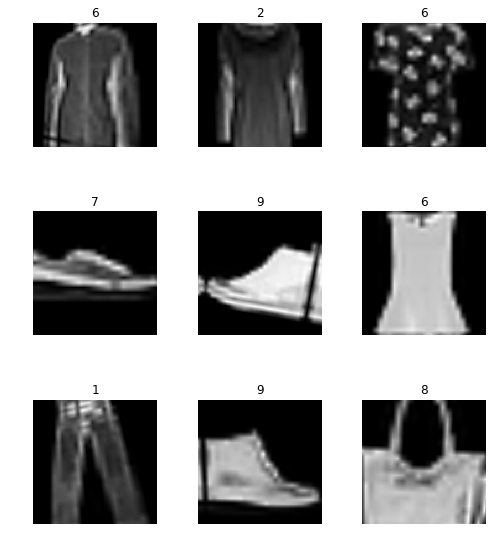

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 10, 48000, 12000)

In [10]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


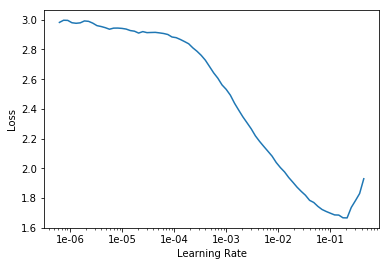

In [12]:
learn.recorder.plot()

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.452349,0.329132,0.878333,07:58
1,0.343713,0.259324,0.908000,07:57
2,0.282100,0.222096,0.920417,07:57
3,0.218077,0.175958,0.935750,07:57
4,0.189914,0.169218,0.937833,07:57


In [15]:
learn.save('stage-1-rn50')

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


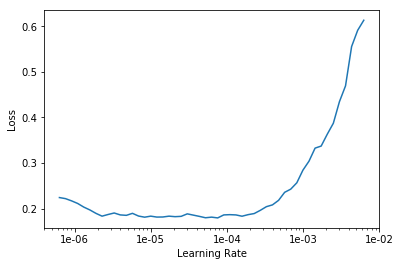

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.263088,0.236328,0.916250,10:29
1,0.231788,0.197474,0.928167,10:28
2,0.198440,0.153602,0.942667,10:29
3,0.137321,0.139582,0.950167,10:28
4,0.117409,0.131560,0.954000,10:28


In [19]:
learn.save('stage-2-rn50')

In [20]:
learn.load('stage-2-rn50');

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

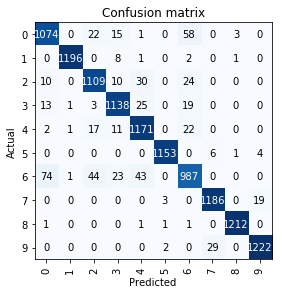

In [22]:
interp.plot_confusion_matrix()

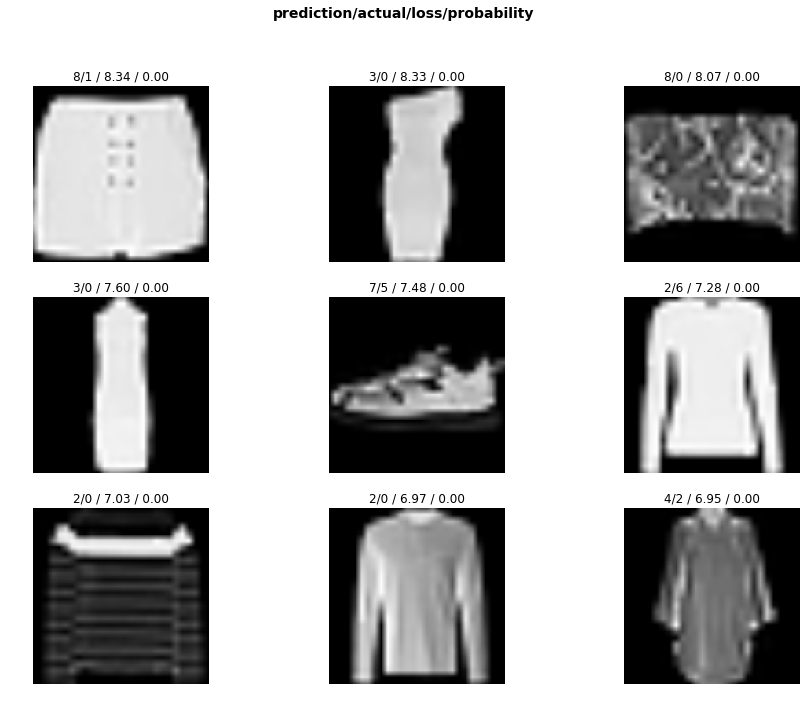

In [23]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [24]:
learn.export()

In [25]:
defaults.device = torch.device('cpu')

In [26]:
learn = load_learner(path)

In [27]:
img = open_image(path/'Images'/'test'/'60005.png')
img

In [28]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 6

In [29]:
test_labels = pd.read_csv('data/apparels/test.csv')

In [30]:
test_images = test_labels['id'].values

In [31]:
test_images[0:10]

array([60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009, 60010])

In [32]:
result_df = pd.DataFrame(columns=['id','label'])

In [ ]:
for idx in range(0,len(test_images)):
    print(idx)
    test_img = test_images[idx].astype(str) + '.png'
    img = open_image(path/'Images'/'test'/test_img)
    pred_class,pred_idx,outputs = learn.predict(img)
    result_df = result_df.append({'id': test_images[idx], 'label': pred_class}, ignore_index=True)

In [ ]:
result_df.head(10)

In [ ]:
result_df.to_csv(path/'apparels_res50_new.csv',index=False)